<a href="https://colab.research.google.com/github/thxsxth/POMDP_RLSepsis/blob/master/RL_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
cd 'drive/My Drive/sepsis3-cohort'

In [ ]:
from dBCQ_modules import discrete_BCQ

### Imports 

In [ ]:
import torch
import numpy as np
import pandas as pd
import datetime as dt
import random
import time
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
import os
import glob
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device='cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
df=pd.read_csv('RL_31.csv')
# df=df.iloc[:,:-1]
print('Loaded')

In [ ]:
act_df=pd.read_csv('./dBCQ/results/corrected_actions.csv')
act_df['SOFA']=SOFA
act_df.head()

In [ ]:
co=pd.read_csv('sepsis3_adults.csv',
               parse_dates=['intime','outtime','suspected_infection_time_poe']) #cohort + demographics
co=co.set_index('icustay_id')

admissions=pd.read_csv('admissions.csv',parse_dates=['ADMITTIME','DISCHTIME','DEATHTIME'])
admissions=admissions.set_index('icustay_id').sort_index()
co['death_time']=admissions['DEATHTIME']

val_df=pd.read_csv('RL_val.csv')

val_df.head()

In [ ]:
val_pats=val_df['pat']
val_dead=set(co[co.death_time.notna()].index).intersection(set(val_pats.values.reshape(-1)))
val_dead=list(val_dead)
len(val_dead)

In [ ]:
temp=df.describe()
means=temp.loc['mean'].values
stds=temp.loc['std'].values

cols=[0,1,2,3,4,5,6,7,11,38,40]

df.iloc[:,cols]=(df.iloc[:,cols]-means[cols])/stds[cols]
val_df.iloc[:,cols]=(val_df.iloc[:,cols]-means[cols])/stds[cols]

print('Normalized')


In [ ]:
ls dBCQ/Action_weighted/

In [273]:
def get_model_load_path(PATH,thresh=0.1):

	dBCQ=discrete_BCQ(
    is_atari=False,
		num_actions=25,
		state_dim=41,
		device=device,
		BCQ_threshold=thresh,
		discount=0.99,
		optimizer="Adam",
		optimizer_parameters={'lr':0.0000625},
		polyak_target_update=True,
		target_update_frequency=8e3,
		tau=0.005,
		initial_eps = 1,
		end_eps = 0.001,
		eps_decay_period = 25e4,
		eval_eps=0
		)
	
	checkpoint=torch.load(PATH, map_location=device)
	dBCQ.I.load_state_dict(checkpoint['I_state_dict'])
	dBCQ.Q.load_state_dict(checkpoint['dBCQ_state_dict'])
	dBCQ.Q_target.load_state_dict(checkpoint['dBCQ_target_state_dict'])
 
	return dBCQ
 
  
 

dBCQ=get_model_load_path('dBCQ/Action_weighted/0_01_1.pt')

In [ ]:
df.head()

### Helper Functions for plots

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [ ]:
def plot_subplots(df=act_df,title=None,cmap=plt.cm.Blues,save=False,filename=None):

  """
  plots 2D historgams of 3 BCQ Policies vs Clinician Policies

  """
  Titles=['Clinician','BCQ 0.1 Threshold','BCQ with Threshold 0.01']
  plt.figure(figsize=(20,20))
  cols=[('Clinician_Vaso','Clinician_Fluids'),('0.1_W_Vaso',	'0.1_W_Fluids'), ('0.01_W_Vaso'	,'0.01_W_Fluids'),
      
        ]
  
  for i in range(1,4):
    plt.subplot(2, 2, i)
    plt.title(Titles[i-1], fontsize=15)
    plt.hist2d(df[cols[i-1][0]],df[cols[i-1][1]],bins=np.arange(6),density=True,cmap=cmap)
    plt.colorbar()
    plt.xlabel('Vasopressor Bin')
    plt.ylabel('Fluid Bin')
    plt.grid()


 
  # if title:
  #   plt.title(title)
  if save:
    plt.savefig(filename)
  plt.show()

In [ ]:
def get_q_vals(pat,model=dBCQ,val=True):
  with torch.no_grad():
    if val:
      state=torch.Tensor(val_df[val_df.pat==pat].iloc[:,:41].values)
    else:
      state=torch.Tensor(df[df.pat==pat].iloc[:,:41].values)
    qs=dBCQ.Q(state)

  return qs
print('HELLO')

In [127]:
def plot_patient_Values(pat,val=True):
   Vals=get_q_vals(pat,val)[:,0].cpu().numpy()
   plt.figure(figsize=(10,5))
   plt.title('Value with Time', fontsize=15)
   
   if val:
    plt.plot(np.arange(Vals.shape[0]),Vals,marker='o',linestyle=':',color='g')

   else:
     plt.plot(np.arange(Vals.shape[0]),Vals,marker='o',linestyle=':',color='r')
   
   plt.xlabel('Time Point')
   plt.ylabel('Approximate Value')
   plt.show()

print(89)

89


In [173]:
def plot_patient_Values_means(pat,val=True):
   Vals=get_q_vals(pat,val).mean(dim=1).cpu().numpy()
   plt.figure(figsize=(10,5))
   plt.title('Value with Time', fontsize=15)
   
   if val:
    plt.plot(np.arange(Vals.shape[0]),Vals,marker='o',linestyle=':',color='g')

   else:
     plt.plot(np.arange(Vals.shape[0]),Vals,marker='o',linestyle=':',color='r')
   
   plt.xlabel('Time Point')
   plt.ylabel('Approximate Value')
   plt.show()

print(89)

89


In [ ]:
pat

289123

## Plotting Values in Validation Cohort

We can see the model correctly identifies risky states in Validation Cohort in advance

Here we plot $Q(S,0)$ as a proxy for the patient value at a state $S$

Note: Theoretically we can compute $V^{\pi}(S)=max_{a'} Q^{\pi}(S,a')$ ,however since we use a fixed batch $Q$ values of unseen state action pairs could be arbitarily bad, so the max operator overestimates the $Q$ values possibly arbiarily bad. $0$ action (No Intervention) is pretty common so we can hope this would provide a better approximation.

I used the model with 0.1 threshold for these

### Here we plot some random patients who have died in the Validation Cohort to see,

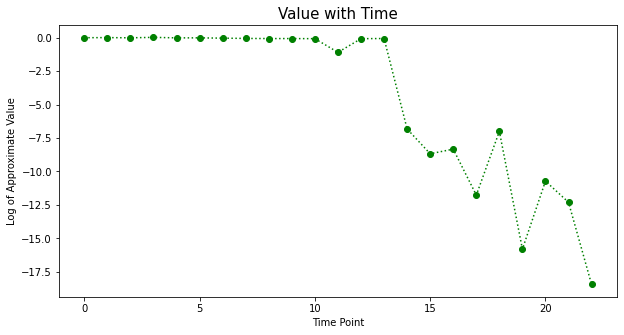

In [ ]:
plot_patient_Values(pat)

Below we plot some patients who have died and examine the trajectory vs our proxy for Value Function

However not all trajectories look as well as below and some don't show a decrease, but considering we are using a proxy for Value Function, it shows the Model has clearly learnt to generalize well

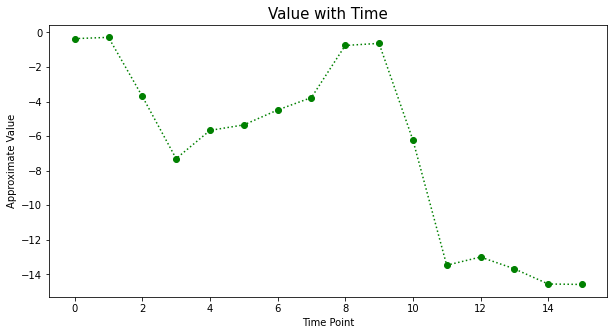

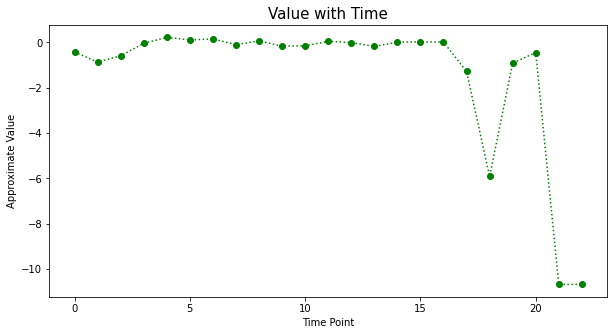

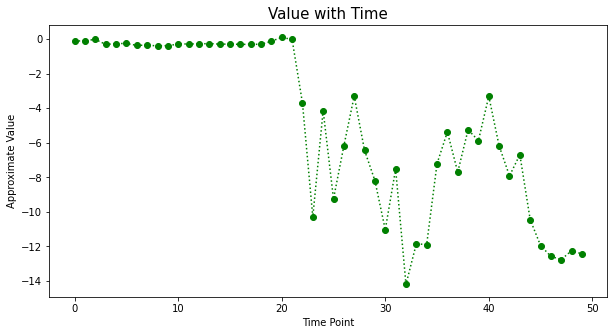

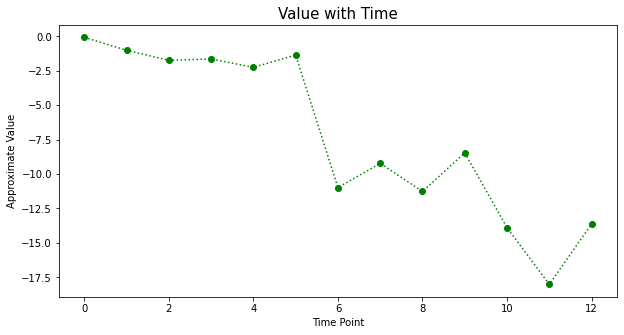

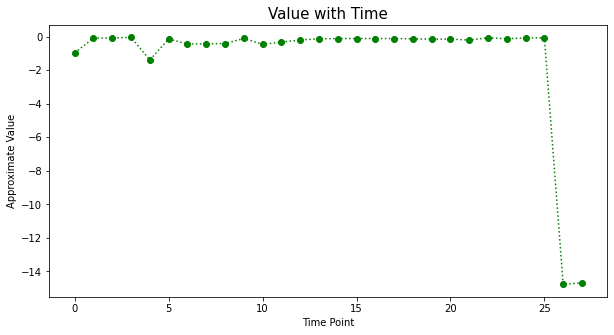

In [ ]:
patients=np.random.choice(val_dead,5)
for pat in patients:
  plot_patient_Values(pat)

In [ ]:
patients

array([223420, 206421, 290518, 270514, 282020])

In [ ]:
patients

array([222040, 228347, 267638, 279889, 259047])

In [243]:
SOFA=act_df.SOFA

### Now for comparison let's plot some patients who survived (Again in the Validation Cohort)

As we can see the Values are all positive, albeit the scale is low. (Also note the y axis has very low values) so fluctuation is not as expansive as suggested by the graphs

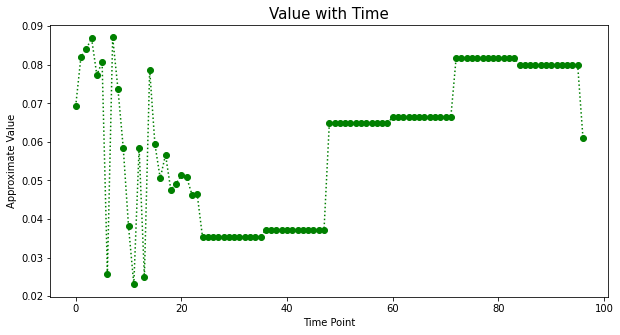

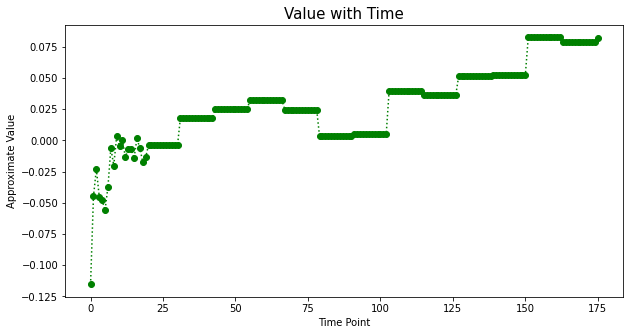

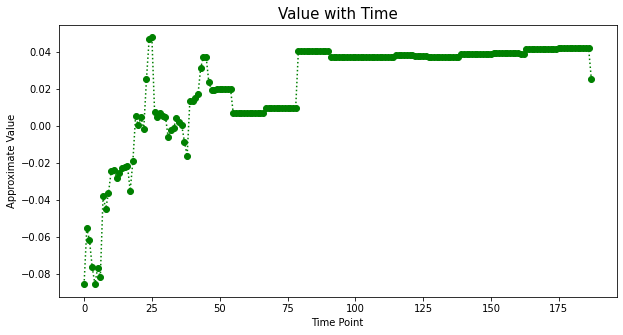

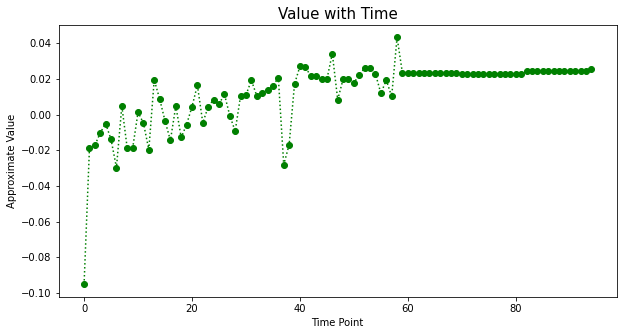

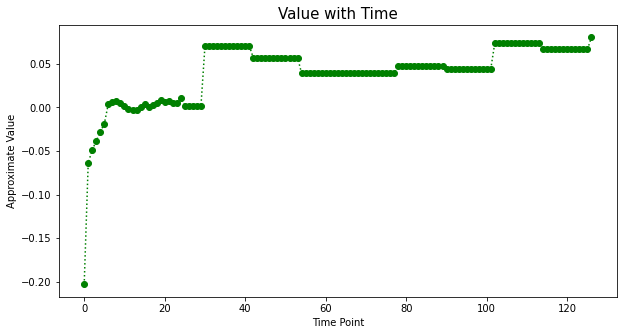

In [234]:
surv_val=list(set(val_pats)-set(val_dead))
pats=np.random.choice(surv_val,5)
for pat in pats:
  plot_patient_Values(pat)

### Another choice could be to try $\Sigma Q(s,a')/|A|$ as our value estimate the following computes that

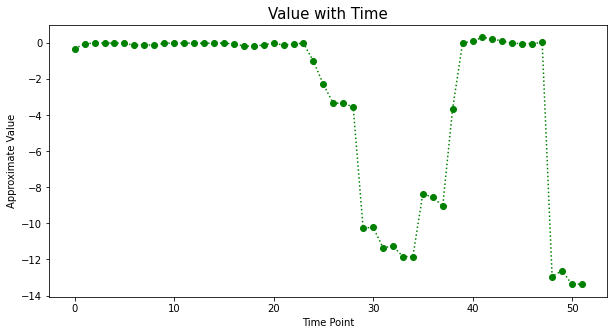

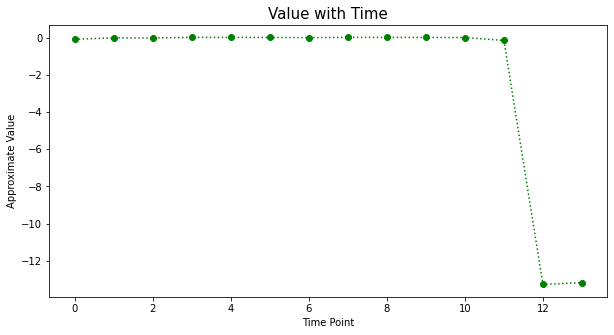

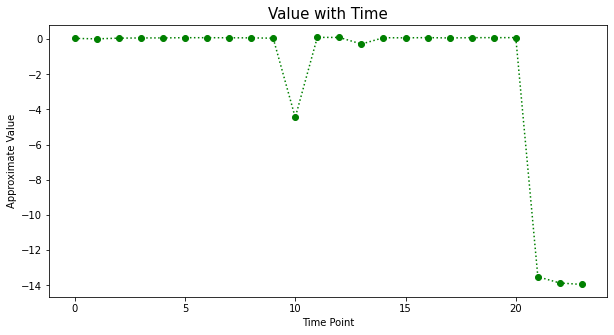

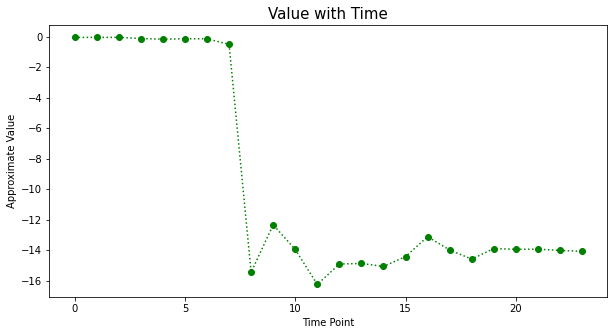

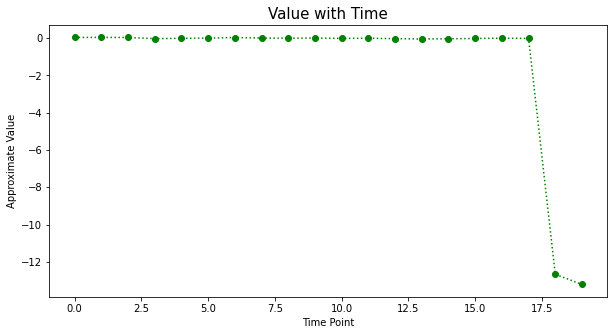

In [179]:
patients=np.random.choice(val_dead,5)
for pat in patients:
  plot_patient_Values(pat)

### Training Set (Patients who have died)

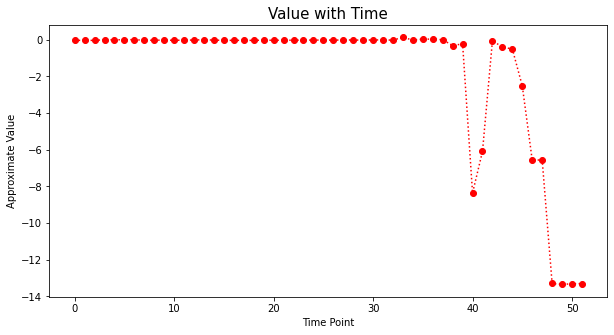

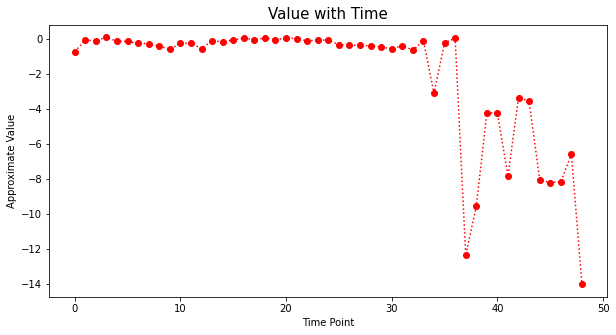

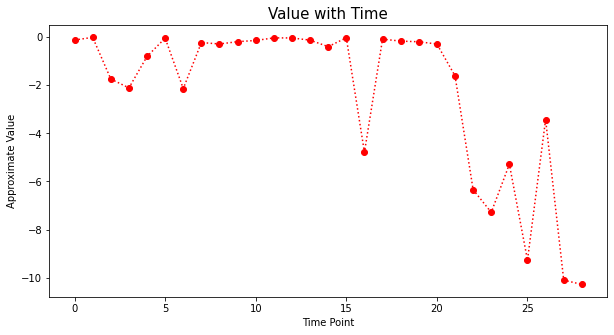

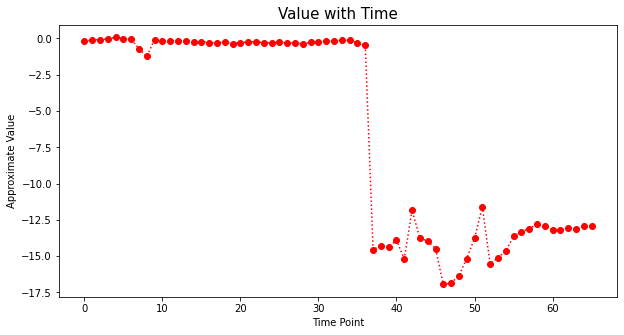

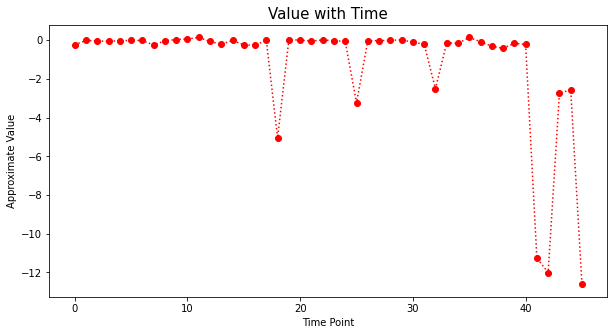

In [212]:
patients=np.random.choice(dead,5)
for pat in patients:
  plot_patient_Values(pat,val=False)

### Training Set Survived

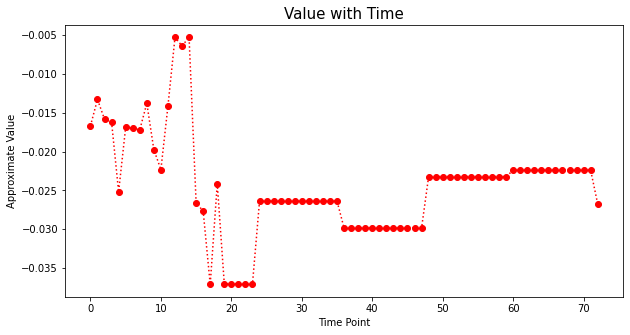

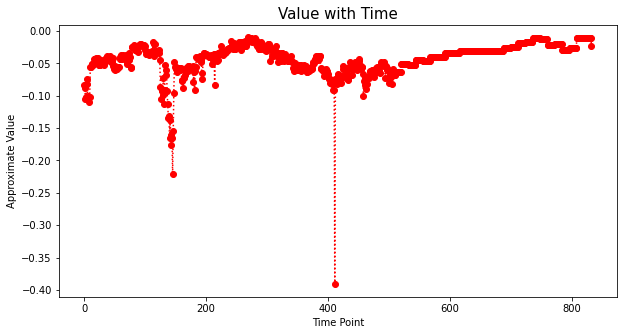

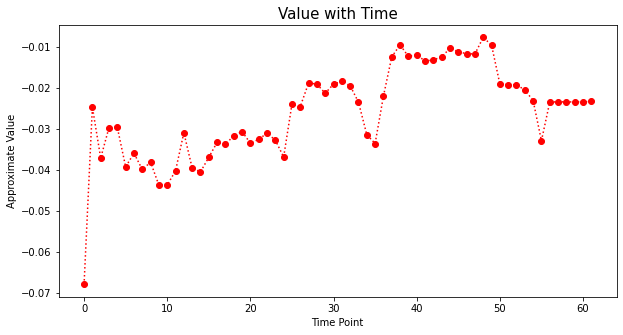

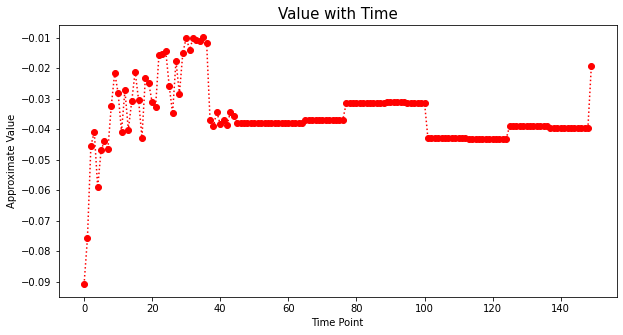

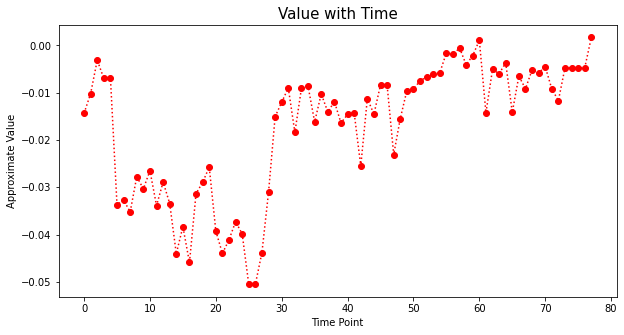

In [195]:
surv=list(set(df.pat)-set(dead))
patients=np.random.choice(surv,5)
for pat in patients:
  plot_patient_Values_means(pat,val=False)

## The following is a 2D histrogram for overall Interventions

Notice that because we are using a hybrid between RL and Behavior Cloning most actions at a first glance agree with Clinicians Actions, but when Sofa is high this is not the case, and also there is significant disgagreement w.r.t dead patients

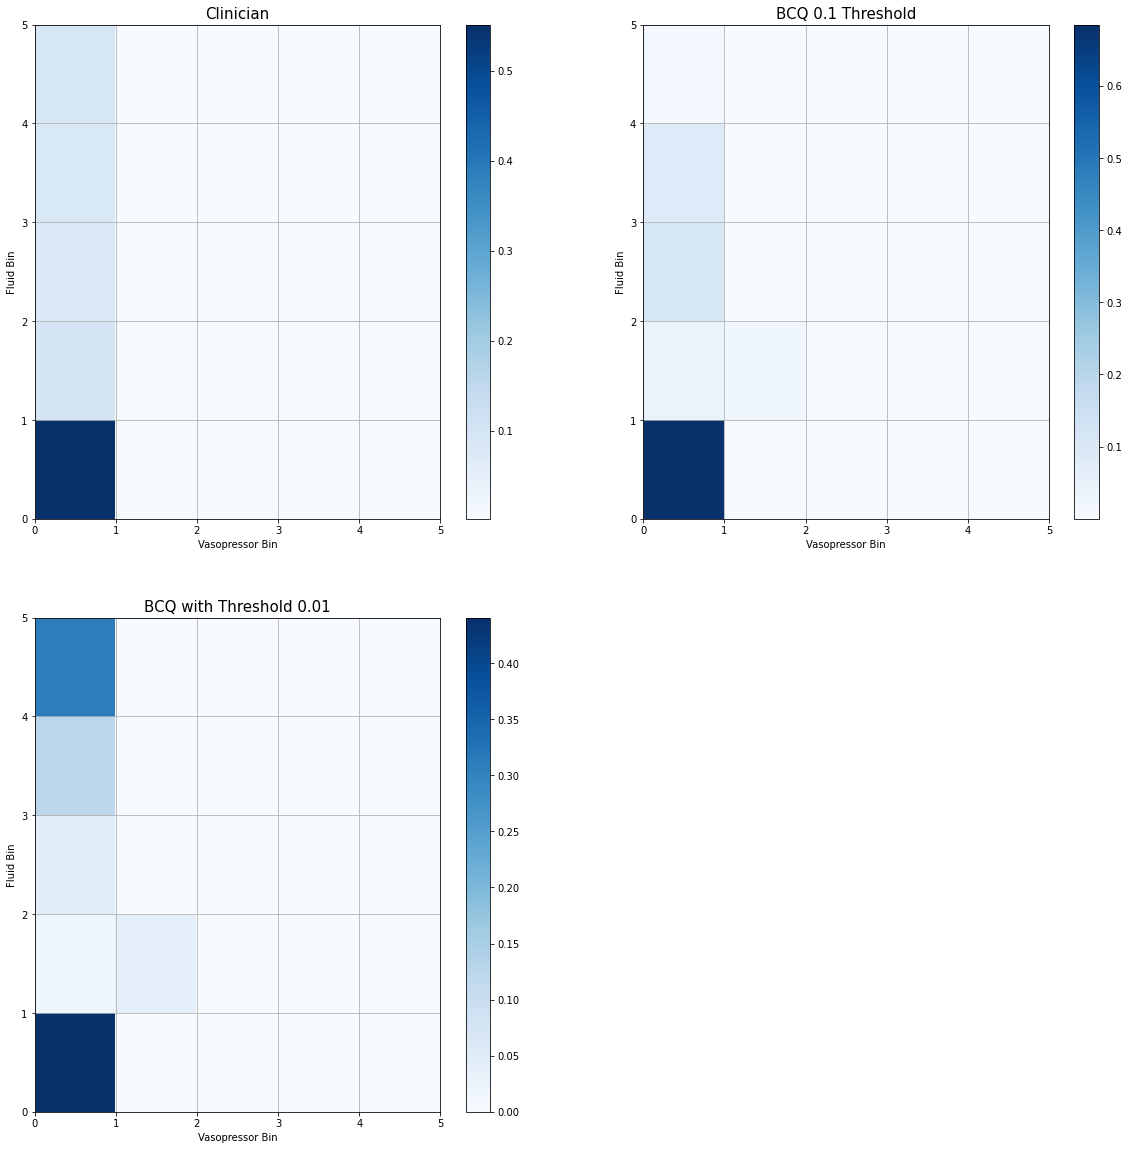

In [304]:
plot_subplots(df=act_df,title=None)


### Now let's do the Sofa Based Analysis

In [151]:
act_df['SOFA']=df['4']
low_sofa=act_df[act_df.SOFA<5]
high_sofa=act_df[act_df.SOFA>=15]
med_sofa=act_df[act_df.SOFA.isin(np.arange(5,15))]
med_sofa.shape[0]+high_sofa.shape[0]+low_sofa.shape[0]

4863208

0         -1.391299
1         -0.835581
2         -0.002005
3         -0.002005
4         -0.002005
             ...   
4863203   -0.557723
4863204   -0.557723
4863205   -0.557723
4863206   -0.557723
4863207   -0.557723
Name: SOFA, Length: 4863208, dtype: float64

In [ ]:
med_sofa.shape[0]+high_sofa.shape[0]+low_sofa.shape[0]

4863208

### LOW SOFA

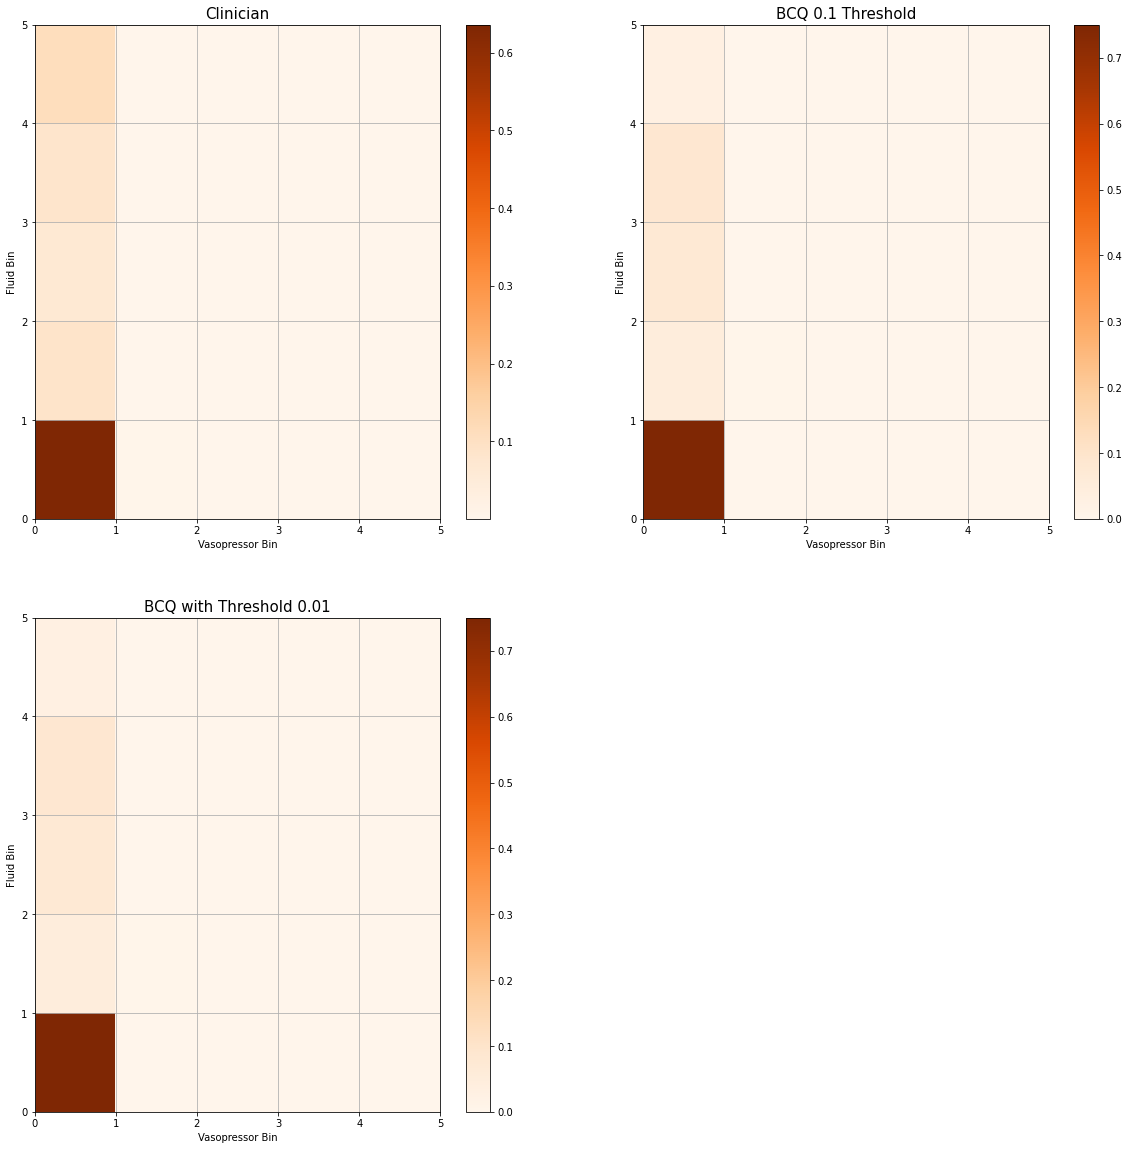

In [305]:
plot_subplots(df=low_sofa,title=None,cmap=plt.cm.Oranges)

### MED SOFA ie 5<=SOFA<=15

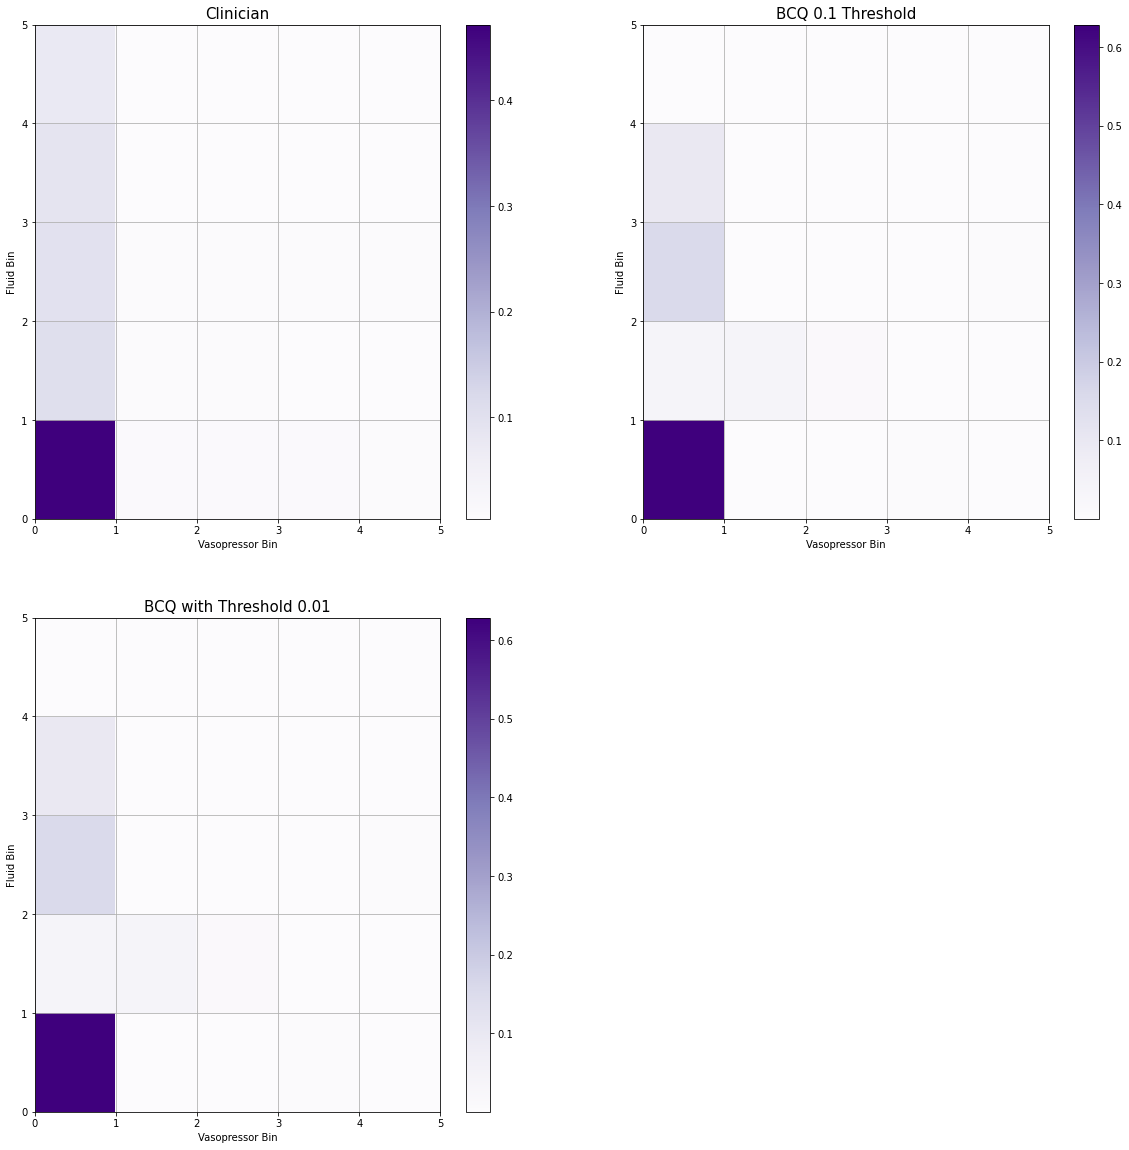

In [306]:
plot_subplots(df=med_sofa,title=None,cmap=plt.cm.Purples)

### High SOFA sofa>15

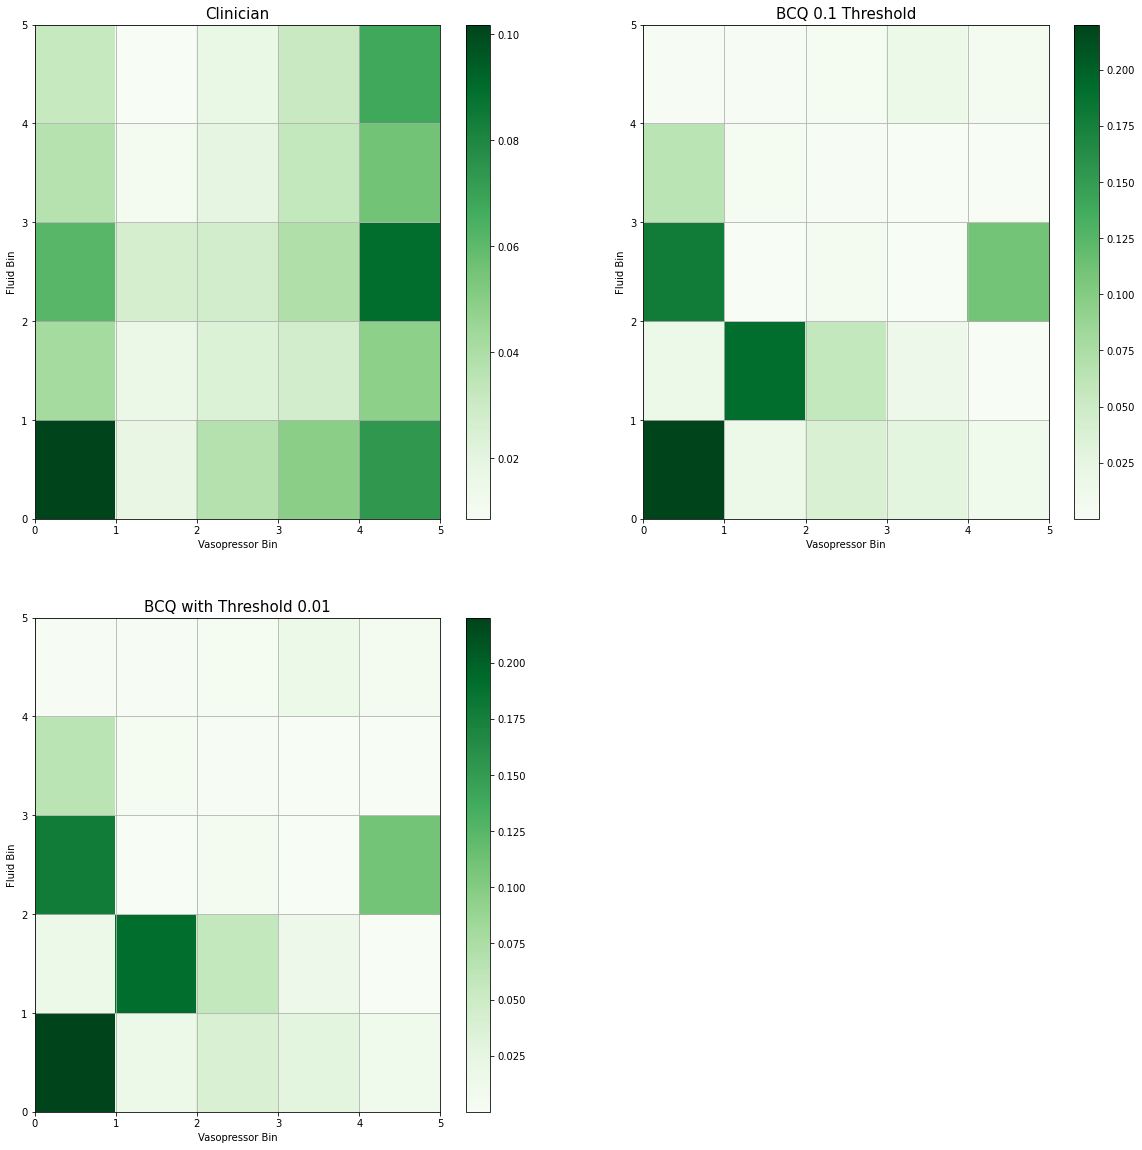

In [307]:
plot_subplots(df=high_sofa,title=None,cmap=plt.cm.Greens)

### For comparison Below is a Screenshot of the DQN paper,  Raghu, Komorowski et al

---



---



But they have only considered first 48 hours of a patient, and also considered 4 hourly windows so the data is sparse in high sofa for them
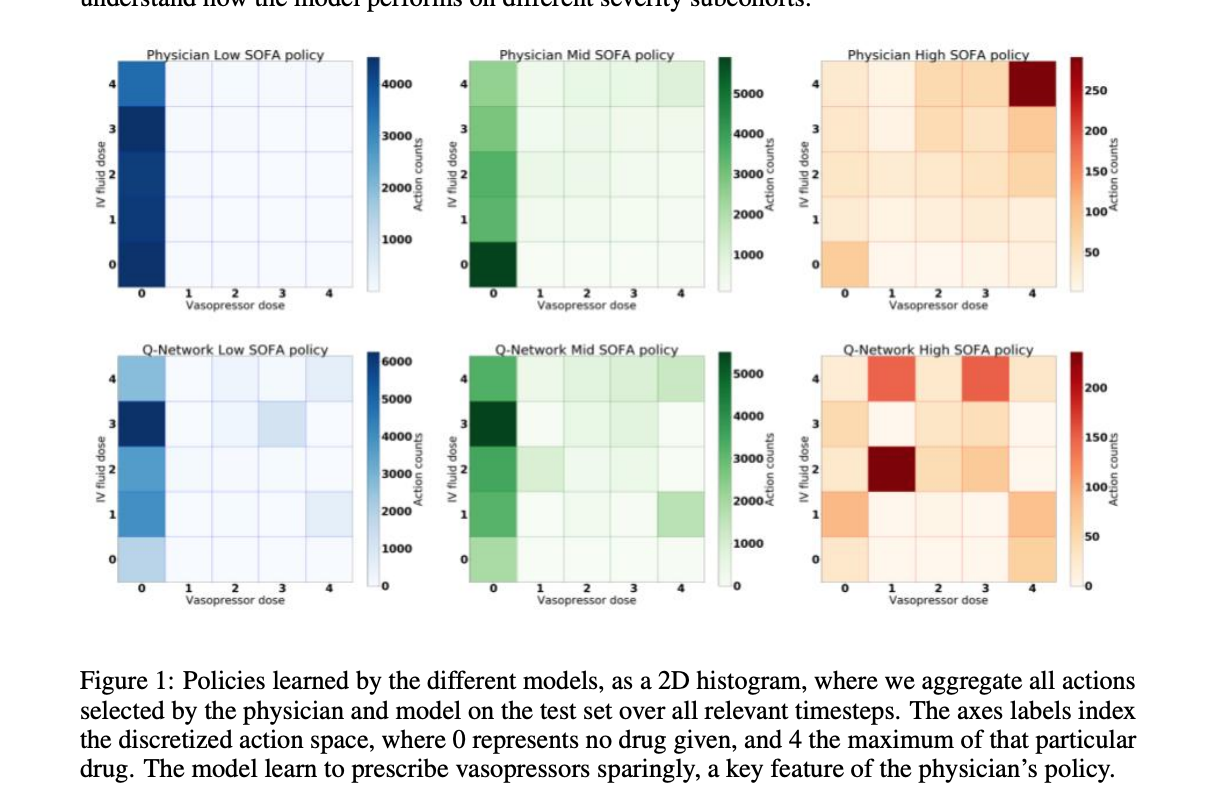

In [116]:
pats=df['pat']
dead=set(co[co.death_time.notna()].index).intersection(set(pats.values.reshape(-1)))
dead=list(dead)
len(dead)

1828

### For patients with ICU deaths 

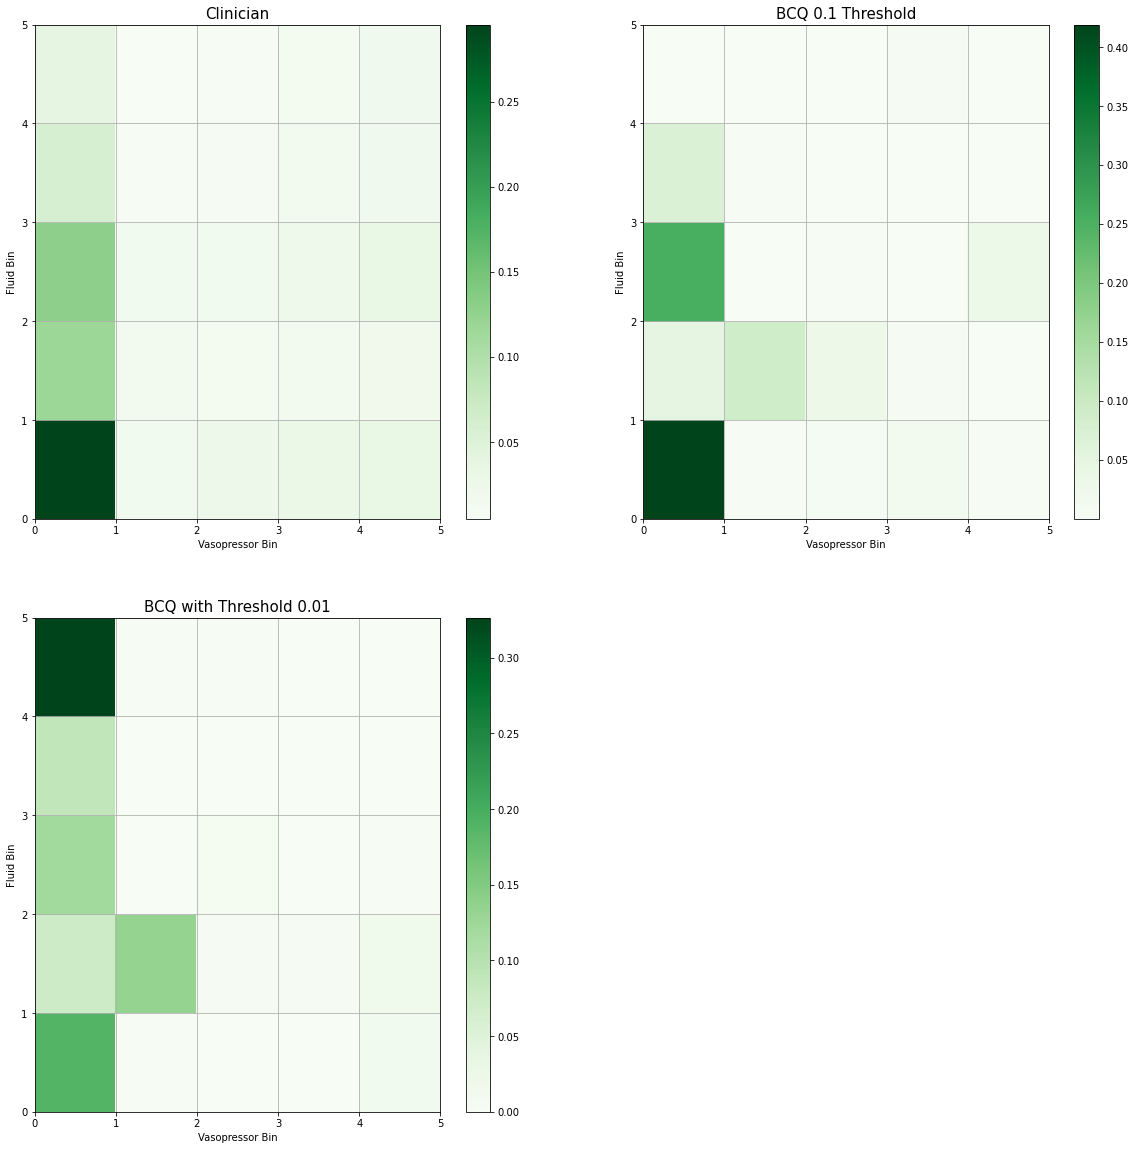

In [308]:
dead_df=act_df[df.pat.isin(dead)]
plot_subplots(df=dead_df,title=None,cmap=plt.cm.Greens)

The following computes statistics of SOFA scores when the Network and Clinician disagree, we can see this SOFA is slighly higher

In [218]:
act_df[act_df.Clinician_Fluids!=act_df['0.1_W_Fluids']].SOFA.describe()

count    1.602687e+06
mean     6.587920e+00
std      4.014950e+00
min      0.000000e+00
25%      4.000000e+00
50%      6.000000e+00
75%      9.000000e+00
max      2.400000e+01
Name: SOFA, dtype: float64

For comparison here are the statistics of SOFA scores

In [220]:
act_df.SOFA.describe()

count    4.863208e+06
mean     5.007215e+00
std      3.598949e+00
min      0.000000e+00
25%      2.000000e+00
50%      4.000000e+00
75%      7.000000e+00
max      2.400000e+01
Name: SOFA, dtype: float64

### Appendix

Value Functions with 0.01 Threshold (Again there were some which didn't agree with expectations)

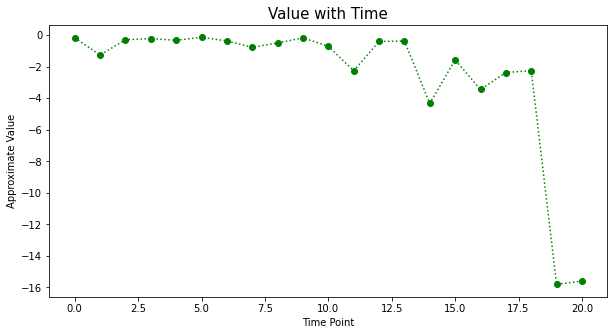

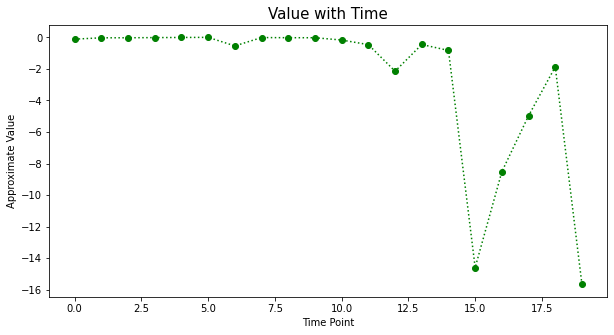

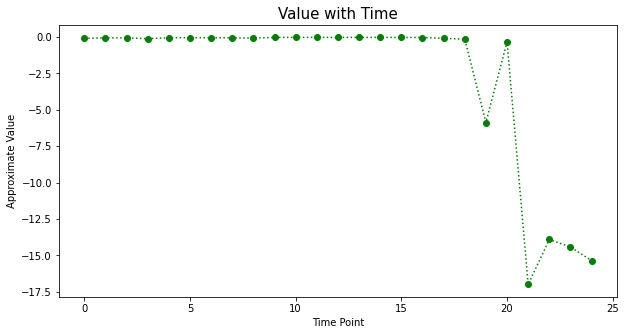

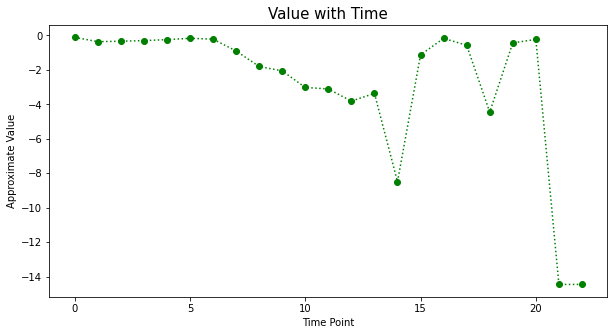

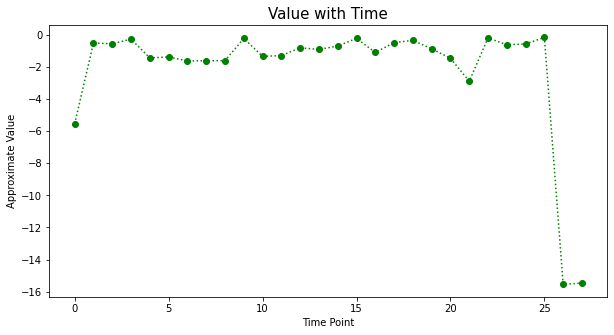

In [282]:
patients=np.random.choice(val_dead,5)
for pat in patients:
  plot_patient_Values(pat)

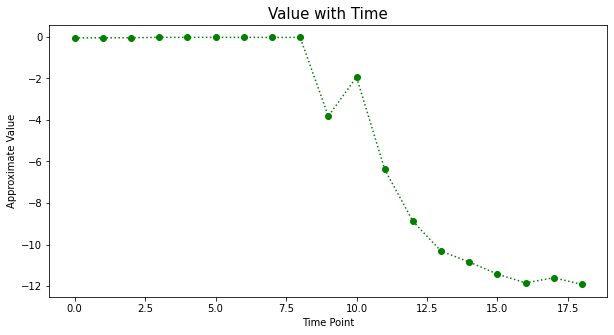

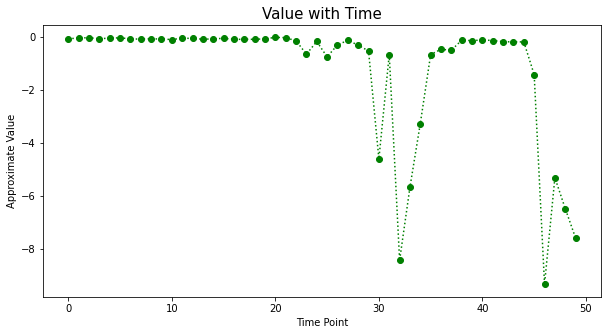

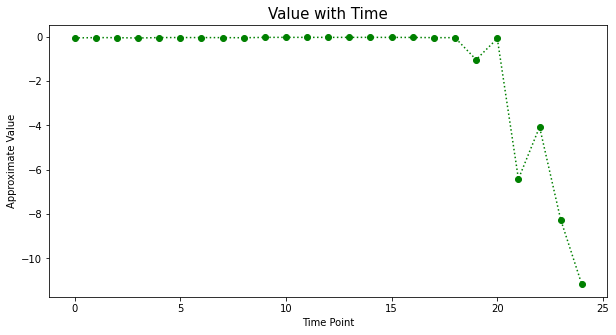

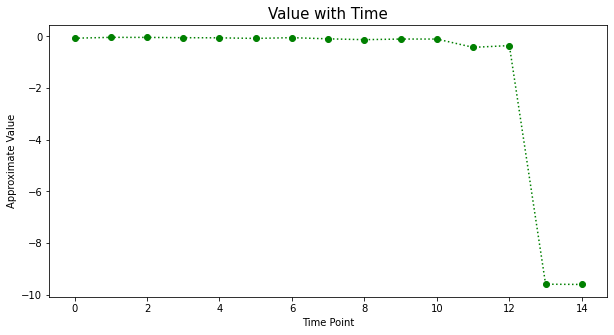

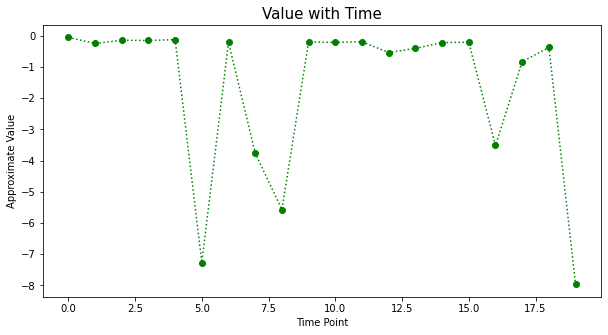

In [302]:
patients=np.random.choice(val_dead,5)
for pat in patients:
  plot_patient_Values_means(pat)